In [1]:
#     Exploratory Data Analysis of Skin Lesion Dataset
#     Copyright (C) 2024  Sebastián A. Cruz Romero

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

# Exploration of AI within Biomedical Applications considering Energy Consumption and Memory Limitations as Model Design Constraints

## Introduction
This notebook is designed to implement a based model to classify images from the `Melanoma Skin Cancer Dataset of 10,000 Images` that can be found in public domain at the [Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data) website. We opt by creating a baseline model, a Fully Convolutional Network (FCN) called Neoplasm Convolutional Network or `NCNet` for short. Our objective is to create a light weight model that makes use of tensor data compression (quantization), multi-process data loading (parallelization), aand considers energy limitations and memory usage constraints (optimal for embedded devices).

### Import Libraries

In [2]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import torch
import cv2 as cv
from PIL import Image
from tqdm import tqdm
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Utils

We have defined several functions to handle and process image data, including retrieving image paths, saving paths to a CSV, plotting image grids, extracting image features, and generating masks for images with lesion outlines. These functions facilitate the preprocessing and visualization of image datasets, aiding in tasks such as machine learning and computer vision.

In [3]:
def get_image_paths(root_dir, extensions=['.jpg', '.png', '.jpeg']):
    """
    Get a list of all image file paths in the root_dir with specified extensions.
    
    Parameters:
    root_dir (str): Root directory to search for image files.
    extensions (list): List of file extensions to include.
    
    Returns:
    list: List of image file paths.
    """
    image_paths = []
    for ext in extensions:
        # Recursively search for files with the given extension
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', f'*{ext}'), recursive=True))
    return image_paths

def save_paths_to_csv(image_paths, csv_file):
    """
    Save image file paths to a CSV file using pandas.
    
    Parameters:
    image_paths (list): List of image file paths.
    csv_file (str): Path to the CSV file where paths will be saved.
    """
    # Create a DataFrame with a single column 'Image Path'
    df = pd.DataFrame(image_paths, columns=['Image Path'])
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file, index=False)

def plot_image_grid(df, image_column='image_path', class_column='class', grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_path = row[image_column]
        img_class = row[class_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def image_features(df, image_column='image_path'):
    """
    Adds image pixel values as features to the DataFrame and normalizes them.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths.
    image_column (str): Column name in the DataFrame that contains image paths.
    
    Returns:
    pd.DataFrame: DataFrame with image pixel values added as new columns, normalized between 0 and 1.
    """
    # Initialize a list to hold the image pixel values
    image_features = []

    for idx, row in df.iterrows():
        img_path = row[image_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Normalize the image array
        img_normalized = img / 255.0
        
        # Flatten the normalized image array and add it to the list
        img_flattened = img_normalized.flatten()
        image_features.append(img_flattened)
    
    # Convert the list of image features to a DataFrame
    image_features_df = pd.DataFrame(image_features)
    df = pd.concat([df.reset_index(drop=True), image_features_df.reset_index(drop=True)], axis=1)
    
    return df 

def generate_mask(df):
    """
    Generate and display a mask for an image with lesion outlines.

    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and classes.

    Returns:
    None
    """
    # Sample an image from the DataFrame
    img = df.sample()
    title = img['Neoplasm Type'].item()

    # Load image from path
    image_path = img['Image Path'].item()
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Generate mask using a simple thresholding technique
    gray_image = cv.cvtColor(image_np, cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(gray_image, 127, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    outlined_image = image_np.copy()
    cv.drawContours(outlined_image, contours, -1, (255, 0, 0), 2)  # Draw in red with thickness 2

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(outlined_image)
    plt.title(f'{title} - Image with Lesion Outline')
    plt.axis('off')

    plt.show()

Moreover, we have defined a `PerformanceMetrics` class that helps in evaluating the performance of classification models. The class provides various metrics such as accuracy, precision, recall, F1 score, log loss, ROC curve, AUC score, and confusion matrix, which are essential for assessing the effectiveness of machine learning models. Feel free to modify and adapt the code and documentation to fit your specific use case.

In [4]:
import torch
from torch.utils.data import Dataset
from sklearn.metrics import log_loss, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

class PerformanceMetrics(Dataset):
    def __init__(self, predicted, actual):
        """
        Initializes the PerformanceMetrics class with predicted and actual values.
        
        Parameters:
        predicted (torch.Tensor): Predicted values from the model.
        actual (torch.Tensor): Actual ground truth values.
        """
        self.predicted = predicted.detach().cpu()
        self.actual = actual.detach().cpu()
        print(self.predicted, self.actual)
        
    def performancemetrics(self, predicted, actual):
        """
        Calculates various performance metrics and returns them as DataFrames.
        
        Parameters:
        predicted (torch.Tensor): Predicted values.
        actual (torch.Tensor): Actual ground truth values.
        
        Returns:
        met_df (pd.DataFrame): DataFrame containing performance metrics.
        cmatrix_df (pd.DataFrame): DataFrame containing confusion matrix values.
        """
        acc = round(accuracy_score(actual, predicted), 3)
        precision = round(precision_score(actual, predicted), 3)
        recall = round(recall_score(actual, predicted), 3)
        f1score = round(f1_score(actual, predicted), 3)
        log = round(log_loss(actual, predicted), 3) # cross entropy loss

        fpr, tpr, _ = roc_curve(actual, predicted)
        auc = roc_auc_score(actual, predicted)

        cmatrix = confusion_matrix(actual, predicted).ravel()
        tn, fp, fn, tp = cmatrix

        cmatrix_df = pd.DataFrame(data=[tp, fp, tn, fn],
                                  index=['True Positive', 'False Positive', 'True Negative', 
                                         'False Negative'],
                                  columns=['Confusion Matrix'])
        
        met_df = pd.DataFrame(data=[acc, precision, recall, f1score, log, fpr, tpr, auc],
                              index=['Accuracy', 'Precision', 'Recall', 'F1 Score',
                                     'Cross Entropy', 'False Positive Rate', 
                                     'True Positive Rate', 'Area Under the Curve'], 
                              columns=['Performance Metrics'])
        return met_df, cmatrix_df
    
# y_pred, y_validate = np.array([[0],[1],[1],[0],[1]]), np.array([[1],[1],[1],[0],[1]])
    
# functiontest = PerformanceMetrics(y_pred, y_validate)
# metrics_df, cmatrix_df = functiontest.performancemetrics(functiontest.predicted, functiontest.actual)
# display(metrics_df)
# display(cmatrix_df)

### Model Architecture

We define data transforms and parameters to load our image dataset in the appropriate format. We defined data augmentations, created a custom dataset class for loading and transforming skin cancer images from CSV files, and set up data loaders for the training and testing datasets. These steps are crucial for preparing the data for training and evaluating machine learning models.

In [5]:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.605, 0.605, 0.605], std=[0.231, 0.231, 0.231])
])


# Create datasets from CSV files (assuming you have a custom dataset class)
class SkinCancerImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Initializes the dataset with a CSV file and optional transformations.
        
        Parameters:
        csv_file (str): Path to the CSV file containing image paths and labels.
        transform (callable, optional): Optional transformations to be applied to the images.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        int: Number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        
        Parameters:
        idx (int): Index of the sample to retrieve.
        
        Returns:
        tuple: (image, target) where image is the transformed image and target is the label.
        """
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        label = str(self.data.iloc[idx, 1])
        target = int(self.data.iloc[idx, 2])
        if self.transform:
            image = self.transform(image)
        return image, target

train_dataset = SkinCancerImageDataset(csv_file='../data/train.csv', transform=transform)
test_dataset = SkinCancerImageDataset(csv_file='../data/test.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

The following script checks if MPS (Metal Performance Shaders) is available on macOS Apple Silicon devices. If MPS is not available, it defaults to using the CPU. This ensures that the code runs on the most efficient hardware available on the user's machine.

In [6]:
device = torch.device('cpu')

# Check for macOS Apple Silicon compatibility
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")

print(f"Selected device: {device}")

Selected device: mps


We define the training and testing loops for a PyTorch model. These loops handle the model's training process by iterating over the data, calculating the loss, updating the model parameters, and evaluating the model's performance. In this example, `train_loop` trains the model and returns the average loss and accuracy for each epoch,while `test_loop` evaluates the model on the test dataset and returns the average loss and accuracy


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Training loop for one epoch.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the training data.
    model (torch.nn.Module): PyTorch model to be trained.
    loss_fn (callable): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    
    Returns:
    tuple: Average loss and average accuracy for the epoch.
    """
    model.train()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []

    for batch_idx, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training"):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y = y.to(torch.float32)
        
        optimizer.zero_grad()
        pred = model(X)

        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        predicted = (pred > 0.5).float()
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
        batch_acc.append(accuracy)
    
    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_accuracy = sum(batch_acc) / len(batch_acc)

    print(f"Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_accuracy

def test_loop(dataloader, model, loss_fn):
    """
    Testing loop to evaluate the model on the test dataset.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the test data.
    model (torch.nn.Module): PyTorch model to be evaluated.
    loss_fn (callable): Loss function.
    
    Returns:
    tuple: Average loss and average accuracy for the test dataset.
    """
    model.eval()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device).unsqueeze(1)
            y = y.to(torch.float32)

            pred = model(X)
            loss = loss_fn(pred, y)

            batch_losses.append(loss.item())
            predicted = (pred > 0.5).float()
            correct = (predicted == y).sum().item()
            accuracy = correct / y.size(0)
            batch_acc.append(accuracy)
    
    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_accuracy = sum(batch_acc) / len(batch_acc)

    return avg_loss, avg_accuracy


Our `NCNet()` class defines a neural network with two convolutional layers, followed by max-pooling layers, and three fully connected layers.

In [8]:
class NCNet(nn.Module):
    def __init__(self):
        super(NCNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 8, 3)

        self.fc1 = nn.Linear(8 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, 1)
        # self.threshold = nn.Threshold(0.5, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = torch.sigmoid(x)
        # x = self.threshold(x)
        x = x.to(torch.float32)
        return x

model = NCNet().to(device)
print(summary(model, (16, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
NCNet                                    [16, 1]                   --
├─Conv2d: 1-1                            [16, 16, 62, 62]          448
├─MaxPool2d: 1-2                         [16, 16, 31, 31]          --
├─Conv2d: 1-3                            [16, 8, 29, 29]           1,160
├─MaxPool2d: 1-4                         [16, 8, 14, 14]           --
├─Linear: 1-5                            [16, 120]                 188,280
├─Linear: 1-6                            [16, 32]                  3,872
├─Linear: 1-7                            [16, 1]                   33
Total params: 193,793
Trainable params: 193,793
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 46.24
Input size (MB): 0.79
Forward/backward pass size (MB): 8.75
Params size (MB): 0.78
Estimated Total Size (MB): 10.31


Now, we create an instance of the `NCNet()` model is created and moved to the specified device (CPU or MPS). The loss function we use, `torch.nn.BCEWithLogitsLoss()`, applies for binary classification tasks. It combines a Sigmoid layer and the Binary Cross-Entropy Loss in one single class, which is more numerically stable than using a plain Sigmoid followed by a BCELoss. Our optimizer function for backpropagation, `torch.optim.Adam` is chosen as the optimizer, which is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. It is initialized with a learning rate of 0.001.

The model is trained for a specified number of epochs `EPOCHS`, in this case, 25. For each epoch, the `train_loop` function is called, which performs a forward pass, computes the loss, backpropagates the error, and updates the model parameters. The average loss and accuracy for each epoch are stored in epoch_losses and epoch_acc lists, respectively. At the end of each epoch, the average loss and accuracy are printed to monitor the training process.


In [9]:
# Initialize model, loss function, and optimizer
model = NCNet().to(device)

# Binary Cross Entropy with Logits Loss function
# Adam optimizer with a learning rate of 0.001
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs to train the model
EPOCHS = 25

# Lists to store the average loss and accuracy for each epoch
epoch_losses = []
epoch_acc = []

for epoch in range(EPOCHS):
    print(f"[======================= Epoch {epoch + 1}/{EPOCHS} =======================]")
    avg_loss, avg_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
    epoch_losses.append(avg_loss)
    epoch_acc.append(avg_accuracy)

print("\n[ Finished Training! ]")

[======================= Epoch 1/25 =======================]


Training: 100%|██████████| 601/601 [00:12<00:00, 47.04it/s]


Avg Loss: 0.3608, Avg Accuracy: 0.8328
[======================= Epoch 2/25 =======================]


Training: 100%|██████████| 601/601 [00:12<00:00, 49.69it/s]


Avg Loss: 0.3163, Avg Accuracy: 0.8551
[======================= Epoch 3/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 50.11it/s]


Avg Loss: 0.3037, Avg Accuracy: 0.8604
[======================= Epoch 4/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 54.92it/s]


Avg Loss: 0.2952, Avg Accuracy: 0.8662
[======================= Epoch 5/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 54.14it/s]


Avg Loss: 0.2912, Avg Accuracy: 0.8674
[======================= Epoch 6/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 51.55it/s]


Avg Loss: 0.2814, Avg Accuracy: 0.8706
[======================= Epoch 7/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 54.64it/s]


Avg Loss: 0.2716, Avg Accuracy: 0.8778
[======================= Epoch 8/25 =======================]


Training: 100%|██████████| 601/601 [00:09<00:00, 62.32it/s]


Avg Loss: 0.2679, Avg Accuracy: 0.8785
[======================= Epoch 9/25 =======================]


Training: 100%|██████████| 601/601 [00:09<00:00, 62.36it/s]


Avg Loss: 0.2600, Avg Accuracy: 0.8837
[======================= Epoch 10/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 54.18it/s]


Avg Loss: 0.2611, Avg Accuracy: 0.8808
[======================= Epoch 11/25 =======================]


Training: 100%|██████████| 601/601 [00:09<00:00, 61.83it/s]


Avg Loss: 0.2560, Avg Accuracy: 0.8837
[======================= Epoch 12/25 =======================]


Training: 100%|██████████| 601/601 [00:09<00:00, 62.98it/s]


Avg Loss: 0.2514, Avg Accuracy: 0.8898
[======================= Epoch 13/25 =======================]


Training: 100%|██████████| 601/601 [00:09<00:00, 64.40it/s]


Avg Loss: 0.2525, Avg Accuracy: 0.8852
[======================= Epoch 14/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 57.93it/s]


Avg Loss: 0.2415, Avg Accuracy: 0.8922
[======================= Epoch 15/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 53.96it/s]


Avg Loss: 0.2426, Avg Accuracy: 0.8935
[======================= Epoch 16/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 58.78it/s]


Avg Loss: 0.2413, Avg Accuracy: 0.8936
[======================= Epoch 17/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 59.00it/s]


Avg Loss: 0.2388, Avg Accuracy: 0.8956
[======================= Epoch 18/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.89it/s]


Avg Loss: 0.2369, Avg Accuracy: 0.9000
[======================= Epoch 19/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.03it/s]


Avg Loss: 0.2377, Avg Accuracy: 0.8968
[======================= Epoch 20/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.31it/s]


Avg Loss: 0.2298, Avg Accuracy: 0.8991
[======================= Epoch 21/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.37it/s]


Avg Loss: 0.2299, Avg Accuracy: 0.8965
[======================= Epoch 22/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.41it/s]


Avg Loss: 0.2322, Avg Accuracy: 0.8965
[======================= Epoch 23/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.82it/s]


Avg Loss: 0.2259, Avg Accuracy: 0.9040
[======================= Epoch 24/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 59.38it/s]


Avg Loss: 0.2246, Avg Accuracy: 0.9032
[======================= Epoch 25/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.10it/s]

Avg Loss: 0.2254, Avg Accuracy: 0.9023

[ Finished Training! ]


To see our training performance, we plot our training loss and accuracy. We create a side-by-side comparison of the training loss and accuracy over the epochs, with smooth trend lines to visualize the overall trend.

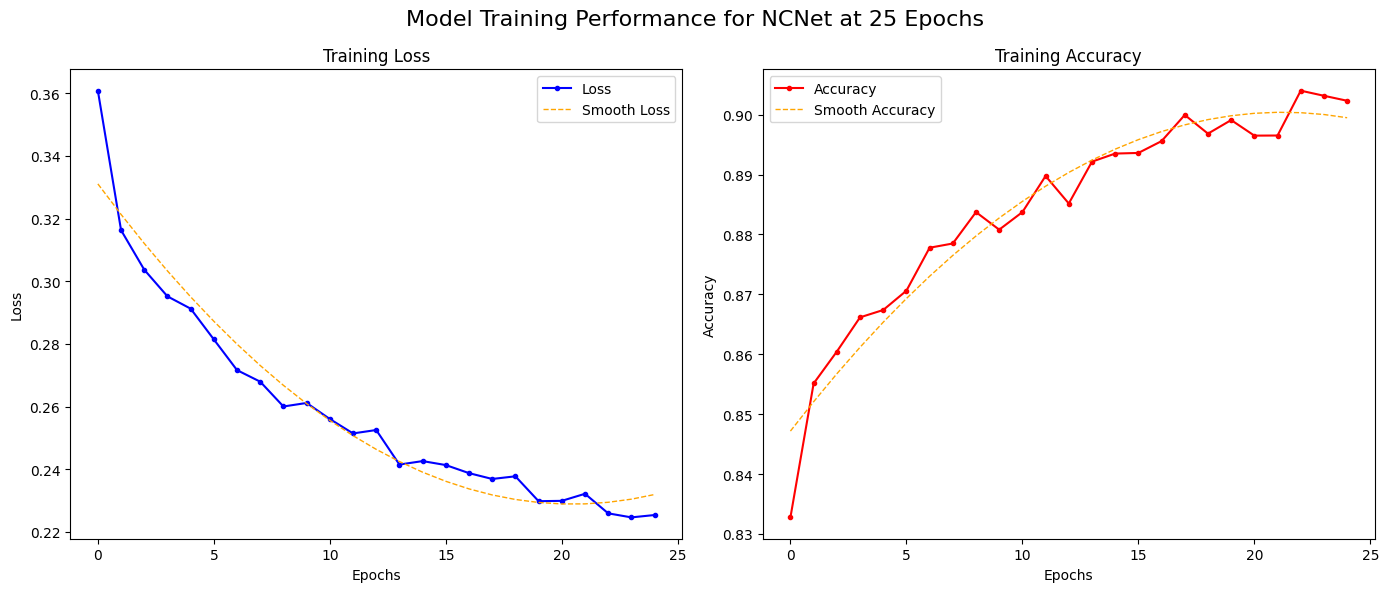

In [10]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training loss with smooth trend line
x = np.arange(len(epoch_losses))
z = np.polyfit(x, epoch_losses, 2)  # Fit a 2nd degree polynomial
p = np.poly1d(z)
ax1.plot(x, epoch_losses, marker='.', linestyle='-', color='b', label='Loss')
ax1.plot(x, p(x), color='orange', linestyle='--', linewidth=1, label='Smooth Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot training accuracy with smooth trend line
x = np.arange(len(epoch_acc))
z = np.polyfit(x, epoch_acc, 2)  # Fit a 2nd degree polynomial
p = np.poly1d(z)
ax2.plot(x, epoch_acc, marker='.', linestyle='-', color='r', label='Accuracy')
ax2.plot(x, p(x), color='orange', linestyle='--', linewidth=1, label='Smooth Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add a header title for the entire figure
fig.suptitle(f'Model Training Performance for NCNet at {EPOCHS} Epochs', fontsize=16)

plt.tight_layout()
plt.show()

We wanto to observe the variability in loss and accuracy across multiple iterations of testing, providing insights into the stability and performance of our model. For 100 `k` iterations, we wish to see test performance of the top 10 best performing inferences.

In [11]:
# Initialize empty lists to store results
test_epoch_losses = []
test_epoch_acc = []

# Perform 100 iterations of testing
for k in range(100):
    if k % 10 == 0:
        print(f"[======================= Random Iterations {k}/100 =======================]")
    
    # Perform testing on the test_loader
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    
    # Append results to lists
    test_epoch_losses.append([k, test_loss])
    test_epoch_acc.append([k, test_accuracy])

# Convert lists to DataFrames and sort for top results
test_epoch_losses_df = pd.DataFrame(test_epoch_losses, columns=['k', 'Best Loss']).sort_values(by='Best Loss', ascending=True)[:10].set_index('k')
test_epoch_acc_df = pd.DataFrame(test_epoch_acc, columns=['k', 'Best Accuracy']).sort_values(by='Best Accuracy', ascending=False)[:10].set_index('k')

# Display the top results for loss and accuracy
display(test_epoch_losses_df, test_epoch_acc_df)

[======================= Random Iterations 0/100 =======================]
[======================= Random Iterations 10/100 =======================]
[======================= Random Iterations 20/100 =======================]
[======================= Random Iterations 30/100 =======================]
[======================= Random Iterations 40/100 =======================]
[======================= Random Iterations 50/100 =======================]
[======================= Random Iterations 60/100 =======================]
[======================= Random Iterations 70/100 =======================]
[======================= Random Iterations 80/100 =======================]
[======================= Random Iterations 90/100 =======================]


,Best Loss
k,
95,0.263373
78,0.264492
5,0.267966
40,0.268050
79,0.268841
94,0.269027
67,0.269484
6,0.269613
1,0.269902


,Best Accuracy
k,
93,0.889881
67,0.889881
91,0.887897
65,0.886905
6,0.886905
7,0.886905
82,0.886905
2,0.886905
55,0.885913
